In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import trimesh
import torch
import numpy as np
import random
import imageio
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import h5py
from tqdm import trange
import meshlabxml as mlx


In [3]:

resy=960
resx=1280
Float = torch.float64
device='cuda'

def cal_valid_mask(src):
    # src = cv2.GaussianBlur(src, (3, 3), 0)
    lap = cv2.Laplacian(src, cv2.CV_64F)
    lap = np.linalg.norm(lap,axis=2)
    mask = (lap>1e-3)*(lap<20)
    # mask = (lap>1e-3)
    # kernel = np.ones((5,5),np.uint8) 
    # mask = cv2.morphologyEx(mask.astype(np.uint8),cv2.MORPH_CLOSE, kernel)
    # mask = cv2.erode(mask.astype(np.uint8), kernel)
    # mask = (mask>0)
    return mask

def limit_hook(grad):
    if torch.isnan(grad).any():
        print("nan in grad")
    grad[torch.isnan(grad)] = 0
    grad[grad>1]=1
    grad[grad<-1]=-1
    # N_part = Render.dot(grad, scene.normals, keepdim=True) * scene.normals
    # grad = N_part + 0.3*(grad-N_part)
    return grad

def interp_L(start, end, it, Pass):
    # 0 <= it <= Pass-1
    assert it <= Pass-1
    step = (end - start)/(Pass-1)
    return it*step + start

def interp_R(start, end, it, Pass):
    return 1/interp_L(1/start, 1/end, it, Pass)

def setup_opt(scene, lr, HyperParams):

    init_vertices = scene.vertices
    parameter = torch.zeros(init_vertices.shape, dtype=Float, requires_grad=True, device=device)    
    # parameter = torch.zeros([init_vertices.shape[0], 1], dtype=Float, requires_grad=True, device=device)    
    parameter.register_hook(limit_hook)
    if HyperParams['optimizer'] == 'sgd':
        opt = torch.optim.SGD([parameter], lr=lr, momentum = HyperParams['momentum'] , nesterov =True)
    if HyperParams['optimizer'] == 'adam':
        opt = torch.optim.Adam([parameter], lr=lr, )
    return init_vertices, parameter, opt

def remesh(scene, meshlab_remesh_srcipt):
    pid = str(os.getpid())
    tmpply = f"/dev/shm/DR/temp_{pid}.ply"
    remeshply = f"/dev/shm/DR/remesh_{pid}.ply"
    # script = "DR/DR/remesh.mlx"
    script = f"/dev/shm/DR/script_{pid}.mlx"
    with open(script, 'w') as script_file:
        script_file.write(meshlab_remesh_srcipt)
    scene.mesh.export(tmpply)
    ssh = "ssh jiahui@172.31.224.138 "
    cmd = "DISPLAY=:1 DR/MeshLabServer2020.04-linux.AppImage -i " + tmpply + " -o "  + remeshply + " -s " + script
    assert(os.system(ssh + cmd + " 1>/dev/null 2>&1") == 0)
    scene.update_mesh(remeshply)
    # os.system('rm '+tmpply)
    # os.system('rm '+remeshply)
    os.system('rm '+script)

def cal_ray_loss(scene, out_origin, out_dir, origin, ray_dir, target, valid):
    # with torch.no_grad():
    #     _, reverse_mask = scene.render_transparent(out_origin, -out_dir)
    render_out_ori, render_out_dir, render_mask = scene.render_transparent(origin, ray_dir)
    target = target  - render_out_ori.detach()
    target = target/target.norm(dim=1, keepdim=True)
    diff = (render_out_dir - target)
    # valid_mask = (diff.norm(dim=1)<1) * valid * render_mask[:,0]
    valid_mask = valid * render_mask[:,0]
    # ray_loss = 1e2*(render_img[twice_mask]-target[twice_mask]).pow(2).mean()
    # ray_loss = 1e2*(diff[valid_mask]).pow(2).mean()
    ray_loss = (diff[valid_mask]).pow(2).mean()

    # render_img = render_img.view((resy,resx,3)).permute(2,0,1)
    # target = target.view((resy,resx,3)).permute(2,0,1)
    # diff = laplac(render_img.unsqueeze(0)) - laplac(target.unsqueeze(0))#[1x3x960x1280]
    # diff = diff.squeeze().permute(1,2,0) #[960x1280x3]
    # diff = diff.view(-1,3)
    # valid_mask = (diff.norm(dim=1)<0.5) * valid * render_twice_mask[:,0]
    # ray_lap_loss = 1e3*(diff[valid_mask]).pow(2).mean()

    return ray_loss

def cal_vh_loss(Views, V_index, scene):
    # silhouette_edge = scene.silhouette_edge(origin[0])
    # index, output = scene.primary_visibility(silhouette_edge, camera_M, origin[0], detach_depth=True)
    # vh_loss = 1e2 * (mask.view((resy,resx))[index[:,1],index[:,0]] - output).abs().mean()
    
    vh_loss = 0
    for v in np.arange(0,72,9):
        index =  (V_index+v)%72
        out_dir, out_origin, valid, mask, origin, ray_dir, camera_M = Views[index]
    # for view in Views:
    #     out_dir, valid, mask, origin, ray_dir, camera_M = view
        R, K, R_inverse, K_inverse = camera_M
        origin = torch.tensor(origin[0], dtype=Float, device=device)
        mask = torch.tensor(mask, dtype=Float, device=device)
        R_inverse = torch.tensor(R_inverse, dtype=Float, device=device)
        K_inverse = torch.tensor(K_inverse, dtype=Float, device=device)
        R = torch.tensor(R, dtype=Float, device=device)
        K = torch.tensor(K, dtype=Float, device=device)
        camera_M = (R, K, R_inverse, K_inverse)
        silhouette_edge = scene.silhouette_edge(origin)
        index, output = scene.primary_visibility(silhouette_edge, camera_M, origin, detach_depth=True)
        vh_loss += (mask.view((resy,resx))[index[:,1],index[:,0]] - output).abs().sum()
    
    return vh_loss

def cal_var_loss(scene, Render):
    # var_loss = 2*scene.area_var()
    # var_loss = 2*scene.edge_var()
    laplac = scene.vertices - scene.weightM.mm(scene.vertices) 
    normals = scene.normals.detach()
    N_laplac = Render.dot(laplac, normals, keepdim=True) * normals
    vertical_laplac = laplac - N_laplac
    var_loss = torch.norm(vertical_laplac/scene.mean_len, dim=1).pow(2).mean()    
    return var_loss

def cal_sm_loss(scene, HyperParams):
    if HyperParams['sm_method'] == 'laplac' :
        laplac = scene.vertices - scene.weightM.mm(scene.vertices) 
        sm_loss = torch.norm(laplac/scene.mean_len, dim=1).pow(2).mean()  
    if HyperParams['sm_method'] == 'fairing' :
        laplac = scene.vertices - scene.weightM.mm(scene.vertices) 
        laplac = laplac - scene.weightM.mm(laplac) 
        sm_loss = torch.norm(laplac/scene.mean_len, dim=1).pow(2).mean()  
    if HyperParams['sm_method'] == 'dihedral' :
        dihedral_angle = scene.dihedral_angle() # cosine of angle [-1,1]
        dihedral_angle = -torch.log(1+dihedral_angle)
        assert not torch.isnan(dihedral_angle).any()
        # sm_loss = dihedral_angle.mean()
        sm_loss = 10*dihedral_angle.mean()/(scene.mean_len)
        # sm_loss = 20*dihedral_angle.mean()/(scene.mean_len*scene.mean_len)
    return sm_loss

def mean_hausd(scene):
    pid = str(os.getpid())
    tmpply = f"/dev/shm/DR/temp_{pid}.ply"
    scene.mesh.export(tmpply)
    logpath = f"/dev/shm/DR/hausd_log_{pid}"
    os.system('rm '+logpath)
    ssh = "ssh jiahui@172.31.224.138 "
    cmd = "DISPLAY=:1 DR/MeshLabServer2020.04-linux.AppImage -i DR/data/hand_gt_align.ply " + tmpply + " -s DR/data/cut_hausd.mlx -l " + logpath
    assert (os.system(ssh+cmd + " 1>/dev/null")==0)
    dist = mlx.compute.parse_hausdorff(logpath)['mean_distance']
    os.system('rm '+tmpply)
    os.system('rm '+logpath)
    return dist

In [59]:
pid = os.getpid()
# os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_num)
import Render_opencv as Render
# Render.extIOR, Render.intIOR = 1.0, 1.4723
# Render.intIOR = HyperParams['IOR']

name = 'hand'
Render.resy = resy
Render.resx = resx
Render.device = device
Render.Float = Float

h5data = h5py.File(f'/root/workspace/data/{name}.h5','r')
Views = []

viewnum = trange(72)
for i in viewnum:
    out_dir = h5data['ray'][i,:,-3:]
    # out_origin = h5data['ray'][i,:,-6:-3]
    out_origin = h5data['cleaned_position'][i,:]
    mask = h5data['mask'][i][:,:,0]
    origin = h5data['ray'][i,:,:3]
    ray_dir = h5data['ray'][i,:,3:6]
    R_inverse = h5data['cam_proj'][i]
    K = h5data['cam_k'][:]
    R = np.linalg.inv(R_inverse)
    K_inverse = np.linalg.inv(K)
    mask = mask//255
    # valid = (cal_valid_mask(out_origin.reshape((resy,resx,3))) * mask).reshape(-1)
    valid = out_origin[:,0] != 0
    M = mask
    if M.max() == 255: M //= 255
    assert M.max() == 1
    bound = 2
    dist= (cv2.distanceTransform(M, cv2.DIST_L2, 0)-0).clip(0,bound)\
     - (cv2.distanceTransform(1-M, cv2.DIST_L2, 0)-1).clip(0,bound) #[-bound,+bound]
    mask = (dist + bound) / (2*bound) #[0,1]

    camera_M = (R, K, R_inverse, K_inverse)
    Views.append((out_dir, out_origin, valid, mask, origin, ray_dir, camera_M))

100%|██████████| 72/72 [00:10<00:00,  7.00it/s]


In [7]:
from sklearn import mixture
def ray_data_center(data, mask):
    g = mixture.GaussianMixture(n_components=2, max_iter=1000)
    g.fit_predict(data[mask.reshape(-1)>0])

    cov0 = np.abs(g.covariances_[0]).sum()
    cov1 = np.abs(g.covariances_[1]).sum()
    main = 0 if cov0 > cov1 else 1
    data_center = g.means_[main]
    return data_center

In [66]:
# Scenes = []
# for IOR in np.arange(1.3,1.7,0.05):
#     scene = Render.Scene(f"/root/workspace/DR/result/{name}/IOR_{IOR}.ply")
#     Scenes.append(scene)
for IOR in np.arange(1.7,1.9,0.05):
    scene = Render.Scene(f"/root/workspace/DR/result/{name}/IOR_{IOR}.ply")
    Scenes.append(scene)

In [11]:
Ray_centers = []
for V_index in trange(72):
    out_dir, out_origin, valid, mask, origin, ray_dir, camera_M = Views[V_index]
    ray_center = ray_data_center(out_origin, mask.reshape(-1))
    ray_center = torch.tensor(ray_center, dtype=Float, device=device)
    Ray_centers.append(ray_center)

100%|██████████| 72/72 [00:12<00:00,  5.60it/s]


In [67]:
# vh_scene = Render.Scene(f"/root/workspace/data/{name}_vh.ply")
vh_scene = Render.Scene(f"/root/workspace/DR/result/{name}_pixel.ply")
# vh_scene = Render.Scene(f"/root/workspace/DR/result/{name}_sm.ply")
IOR = np.arange(1.3,1.9,0.05)
# IOR = np.arange(1.1,1.9,0.02)
indexs = list(np.arange(-4, 5))
indexs = indexs + list(np.arange(32,42))
Error = [0] * len(IOR)
# for V_index in trange(72):
for V_index in indexs:
    ray_center = Ray_centers[V_index]
    out_dir, out_origin, valid, mask, origin, ray_dir, camera_M = Views[V_index]
    R, K, R_inverse, K_inverse = camera_M
    out_dir = torch.tensor(out_dir, dtype=Float, device=device)
    out_origin = torch.tensor(out_origin, dtype=Float, device=device)
    valid = torch.tensor(valid, dtype=bool, device=device)
    mask = torch.tensor(mask, dtype=Float, device=device)
    origin = torch.tensor(origin, dtype=Float, device=device)
    ray_dir = torch.tensor(ray_dir, dtype=Float, device=device)
    R_inverse = torch.tensor(R_inverse, dtype=Float, device=device)
    K_inverse = torch.tensor(K_inverse, dtype=Float, device=device)
    R = torch.tensor(R, dtype=Float, device=device)
    K = torch.tensor(K, dtype=Float, device=device)
    camera_M = (R, K, R_inverse, K_inverse)
    target = out_origin

    for i in range(len(IOR)):
        scene = Scenes[i]
        Render.intIOR = IOR[i]
        render_out_ori, render_out_dir, render_mask = scene.render_transparent(origin, ray_dir)
        # render_out_ori, render_out_dir, render_mask = vh_scene.render_transparent(origin, ray_dir)
        Error[i] += (render_mask[:,0].sum() - valid.sum()).abs()


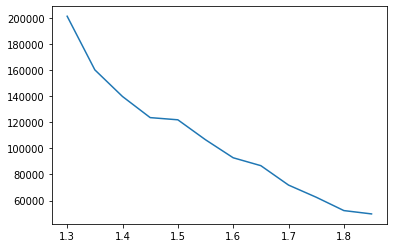

In [68]:
plt.plot(IOR, Error)

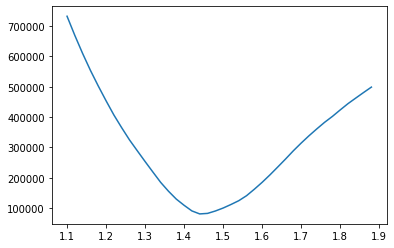

In [58]:
plt.plot(IOR, Error)

In [60]:
Scenes[0]

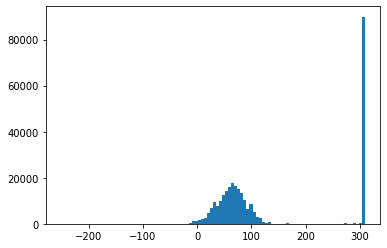

In [141]:
_=plt.hist(out_ori[mask.reshape(-1)>0,1],bins=100)